# PART 2
# _*Time Series Forecasting with Neural Network*_
## Bitcoin Price Prediction Model

Setup the notebook.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
from IPython.display import HTML

from fastai.structured import *
from fastai.column_data import *

np.set_printoptions(threshold=50, edgeitems=20)

# The Data 

In [3]:
PATH='data/btc/'
fname = 'btc-final.csv'

In [4]:
data = pd.read_csv(f'{PATH}{fname}', low_memory=False, sep = '\t') 
data.head()

,yprice,yret,ylab,date,price_open,price_high,price_low,price_close,volume,close_price_returns,...,rolling_10_return,rolling_10_return_labels,rolling_10_seq_down,rolling_10_seq_up,rolling_20_volume,rolling_20_volume_over_max,rolling_20_return,rolling_20_return_labels,rolling_20_seq_down,rolling_20_seq_up
1,300.0,0.000000,4,2014-12-01 00:30:00,300.0,300.0,300.0,300.0,0.01,0.000000,...,0.0,4,0,0,0.01,0.000004,0.0,4,0,0
2,370.0,0.000000,4,2014-12-01 00:35:00,300.0,300.0,300.0,300.0,0.00,0.000000,...,0.0,4,0,0,0.01,0.000004,0.0,4,0,0
3,370.0,23.333333,9,2014-12-01 00:40:00,300.0,300.0,300.0,300.0,0.01,0.000000,...,0.0,4,0,0,0.01,0.000004,0.0,4,0,0
4,370.0,0.000000,4,2014-12-01 00:45:00,370.0,370.0,370.0,370.0,0.00,23.333333,...,0.0,4,0,0,0.01,0.000004,0.0,4,0,0
5,370.0,0.000000,4,2014-12-01 00:50:00,370.0,370.0,370.0,370.0,0.00,0.000000,...,0.0,4,0,0,0.01,0.000004,0.0,4,0,0


## Filter

Trading ins't very active before the end of January 2015 so lets start there.

In [5]:
df = data[data['date'] > '2015-01-27']
n = df.shape[0]
n

326818

In [6]:
df = df.reset_index()
df = df.drop('index', 1)

### Backup Tables

It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [7]:
print(len(df))

326818


##### Saving Table

In [8]:
df.to_feather(f'{PATH}df')

##### Loading Table

In [9]:
df = pd.read_feather(f'{PATH}df')

In [10]:
df["date"] = pd.to_datetime(df.date)

In [11]:
# df.head(5)

# Train and Test

In [12]:
split_train = 0.8

In [13]:
n_train = int(split_train * n)
df_train = df.iloc[0:n_train]
df_test = df.iloc[n_train+1:n-1]

In [14]:
# df_train.head().T

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [15]:
df.columns

Index(['yprice', 'yret', 'ylab', 'date', 'price_open', 'price_high',
       'price_low', 'price_close', 'volume', 'close_price_returns',
       'close_price_returns_labels', 'UP', 'DOWN', 'HOLD', 'year', 'month',
       'week', 'day', 'dayofweek', 'dayofyear', 'DateTime_UTCElapsed',
       'Since_01', 'Since_025', 'Since_05', 'Since_075', 'Since_1', 'Since_2',
       'Since_3', 'Since_4', 'Since_5', 'Since_01_down', 'Since_025_down',
       'Since_05_down', 'Since_075_down', 'Since_1_down', 'Since_2_down',
       'Since_3_down', 'Since_4_down', 'Since_5_down', 'Since_01_up',
       'Since_025_up', 'Since_05_up', 'Since_075_up', 'Since_1_up',
       'Since_2_up', 'Since_3_up', 'Since_4_up', 'Since_5_up', 'SinceUP',
       'SinceDown', 'hour', 'minute', 'up', 'down', 'per_high', 'per_low',
       'rolling_3_volume', 'rolling_3_volume_over_max', 'rolling_3_return',
       'rolling_3_return_labels', 'rolling_3_seq_down', 'rolling_3_seq_up',
       'rolling_7_volume', 'rolling_7_volume_over

## Variable Type Selection
I'm going to have different groups of continuous and catigorical variables to provide to the model.

### All Variables
This is all the variables for each type. Not going to start with this though...

##### Continuous Variables

In [ ]:
#rolling_3_volume mean
#rolling_3_return mean
contin_vars = [
    'price_open',
    'price_high',
    'price_low',
    'per_high',
    'per_low',
    'price_close',
    'volume',
    'close_price_returns',
    'DateTime_UTCElapsed',
    'rolling_3_volume_over_max',
    'rolling_7_volume_over_max',
    'rolling_10_volume_over_max',
    'rolling_20_volume_over_max',
    'rolling_3_return',
    'rolling_7_return',
    'rolling_10_return',
    'rolling_20_return',
    'rolling_3_volume',
    'rolling_7_volume',
    'rolling_10_volume',
    'rolling_20_volume']
    

##### Catigorical Variables

In [ ]:
#rolling_3_return_labels mean rounded int
#rolling_3_seq_down sum
#rolling_3_seq_up sum
cat_vars = ['close_price_returns_labels',
    'UP',
    'DOWN',
    'HOLD',
    'up',
    'down',
    'year',
    'month',
    'week',
    'day',
    'hour',
    'minute',
    'dayofweek',
    'dayofyear',
    'rolling_3_return_labels',
    'rolling_7_return_labels',
    'rolling_10_return_labels',
    'rolling_20_return_labels',    
    'rolling_3_seq_down',
    'rolling_7_seq_down',
    'rolling_10_seq_down',
    'rolling_20_seq_down',
    'rolling_3_seq_up',
    'rolling_7_seq_up',
    'rolling_10_seq_up',
    'rolling_20_seq_up']

##### Undecided on Type

In [ ]:
undecided_vars = [
    'Since_01',
    'Since_025',
    'Since_05',
    'Since_075',
    'Since_1',
    'Since_2',
    'Since_3',
    'Since_4',
    'Since_5',
    'Since_01_down',
    'Since_025_down',
    'Since_05_down',
    'Since_075_down',
    'Since_1_down',
    'Since_2_down',
    'Since_3_down',
    'Since_4_down',
    'Since_5_down',
    'Since_01_up',
    'Since_025_up',
    'Since_05_up',
    'Since_075_up',
    'Since_1_up',
    'Since_2_up',
    'Since_3_up',
    'Since_4_up',
    'Since_5_up',
    'SinceUP',
    'SinceDown']

### Minimal
I'm going to start with a small number.

##### Continuous Variables

In [16]:
#rolling_3_volume mean
#rolling_3_return mean
contin_vars = [
#     'price_open',
#     'price_high',
#     'price_low',
#     'per_high',
#     'per_low',
    'price_close',
    'volume',
    'close_price_returns',
    'rolling_3_volume_over_max',
#     'rolling_7_volume_over_max',
#     'rolling_10_volume_over_max',
#     'rolling_20_volume_over_max',
#     'rolling_3_return',
    'rolling_7_return',
#     'rolling_10_return',
#     'rolling_20_return',
    'rolling_3_volume'
#     'rolling_7_volume',
#     'rolling_10_volume',
#     'rolling_20_volume'
]
    

##### Catigorical Variables

In [17]:
#rolling_3_return_labels mean rounded int
#rolling_3_seq_down sum
#rolling_3_seq_up sum
cat_vars = [
    'close_price_returns_labels',
    'UP',
    'DOWN',
    'HOLD',
#     'up',
#     'down',
    'year',
    'month',
    'week',
    'day',
    'hour',
    'minute',
    'dayofweek',
    'dayofyear',
#     'rolling_3_return_labels',
    'rolling_7_return_labels',
#     'rolling_10_return_labels',
    'rolling_20_return_labels',    
#     'rolling_3_seq_down',
#     'rolling_7_seq_down',
    'rolling_10_seq_down',
#     'rolling_20_seq_down',
#     'rolling_3_seq_up',
#     'rolling_7_seq_up',
    'rolling_10_seq_up'
#     'rolling_20_seq_up'
]

##### Undecided on Type

In [18]:
undecided_vars = [
#     'Since_01',
#     'Since_025',
#     'Since_05',
#     'Since_075',
    'Since_1',
    'Since_2',
    'Since_3',
    'Since_4',
    'Since_5',
    'Since_01_down',
    'Since_025_down',
    'Since_05_down',
    'Since_075_down',
#     'Since_1_down',
#     'Since_2_down',
#     'Since_3_down',
#     'Since_4_down',
#     'Since_5_down',
    'Since_01_up',
    'Since_025_up',
    'Since_05_up',
    'Since_075_up'
#     'Since_1_up',
#     'Since_2_up',
#     'Since_3_up',
#     'Since_4_up',
#     'Since_5_up',
#     'SinceUP',
#     'SinceDown'
]

In [19]:
contin_vars = contin_vars + ['Since_1', 'Since_2', 'Since_3', 'Since_4', 'Since_5']
cat_vars = cat_vars + ['Since_01_down', 'Since_025_down', 'Since_05_down', 'Since_075_down', 
            'Since_01_up', 'Since_025_up', 'Since_05_up', 'Since_075_up']

## Split Test/Train

In [20]:
joined = df_train
joined_test = df_test
n = len(joined); n

261454

## Select Rows

In [21]:
dep = 'yret'
# dep = 'ylab'
joined = joined[cat_vars+contin_vars+[dep, 'date']].copy()

In [22]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'date']].copy()

/home/liam/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [24]:
apply_cats(joined_test, joined)

In [25]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

## Final Data Set

### Smaller Sample Set

We're going to run on a sample.

In [ ]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("date")
samp_size = len(joined_samp); samp_size

### Full Data Set

To run on the full dataset, use this instead:

In [26]:
samp_size = n
joined_samp = joined.set_index("date")

### Proceed

We can now process our data...

In [27]:
joined_samp.head(2)

,close_price_returns_labels,UP,DOWN,HOLD,year,month,week,day,hour,minute,...,close_price_returns,rolling_3_volume_over_max,rolling_7_return,rolling_3_volume,Since_1,Since_2,Since_3,Since_4,Since_5,yret
date,,,,,,,,,,,,,,,,,,,,,
2015-01-27 00:00:00,9,1,0,0,2015,1,5,27,0,0,...,0.303228,0.017324,0.188158,15.49213,3.0,24.0,47.0,262.0,262.0,0.068881
2015-01-27 00:05:00,7,1,0,0,2015,1,5,27,0,5,...,0.068881,0.006181,0.165323,5.52768,4.0,25.0,48.0,263.0,263.0,0.168260


In [32]:
df, y, nas, mapper = proc_df(joined_samp, 'yret', do_scale=True)
# yl = np.log(y)

In [33]:
joined_test = joined_test.set_index("date")

In [34]:
df_test, _, nas, mapper = proc_df(joined_test, 'yret', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [35]:
df.head(2)

,close_price_returns_labels,UP,DOWN,HOLD,year,month,week,day,hour,minute,...,volume,close_price_returns,rolling_3_volume_over_max,rolling_7_return,rolling_3_volume,Since_1,Since_2,Since_3,Since_4,Since_5
date,,,,,,,,,,,,,,,,,,,,,
2015-01-27 00:00:00,10,2,1,1,1,1,5,27,1,1,...,-0.375253,1.363810,-0.267573,2.406089,-0.267573,-0.797714,-0.942426,-1.017001,-1.170923,-1.115786
2015-01-27 00:05:00,8,2,1,1,1,1,5,27,1,2,...,-0.494138,0.305761,-0.463419,2.112272,-0.463419,-0.797142,-0.942231,-1.016916,-1.170857,-1.115757


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [36]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [ ]:
val_idx=[0]

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [40]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.log(np.max(y))
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [42]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [43]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [44]:
cat_sz

[('close_price_returns_labels', 11),
 ('UP', 3),
 ('DOWN', 3),
 ('HOLD', 3),
 ('year', 4),
 ('month', 13),
 ('week', 54),
 ('day', 32),
 ('hour', 25),
 ('minute', 13),
 ('dayofweek', 8),
 ('dayofyear', 367),
 ('rolling_7_return_labels', 11),
 ('rolling_20_return_labels', 9),
 ('rolling_10_seq_down', 12),
 ('rolling_10_seq_up', 12),
 ('Since_01_down', 822),
 ('Since_025_down', 1649),
 ('Since_05_down', 6006),
 ('Since_075_down', 8238),
 ('Since_01_up', 952),
 ('Since_025_up', 3143),
 ('Since_05_up', 7284),
 ('Since_075_up', 15127)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [45]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [46]:
emb_szs

[(11, 6),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (13, 7),
 (54, 27),
 (32, 16),
 (25, 13),
 (13, 7),
 (8, 4),
 (367, 50),
 (11, 6),
 (9, 5),
 (12, 6),
 (12, 6),
 (822, 50),
 (1649, 50),
 (6006, 50),
 (8238, 50),
 (952, 50),
 (3143, 50),
 (7284, 50),
 (15127, 50)]

In [47]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [48]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                   
    0      0.035567   0.089538  



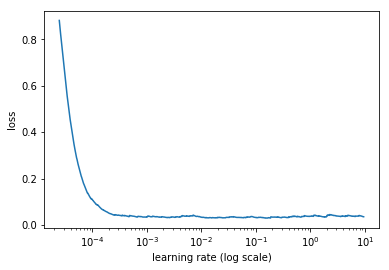

In [49]:
m.sched.plot(100)

### Sample

In [50]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4

In [51]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.03468    0.089598   41977.968577
    1      0.033074   0.08954    41890.014941                    
    2      0.034743   0.089532   41867.346061                    



[0.08953248, 41867.346060982665]

In [52]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.038806   0.089571   42177.773482
    1      0.033995   0.089589   42507.205797                    
    2      0.031666   0.090193   42942.505098                    
    3      0.035312   0.089948   43157.117566                    
    4      0.034578   0.091361   42664.562529                    



[0.09136061, 42664.562528532006]

In [53]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.032469   0.092586   42598.641058
    1      0.031514   0.097641   42457.912511                    
    2      0.031053   0.094542   42575.154794                    
    3      0.032682   0.093343   42392.828657                    
    4      0.033357   0.093207   42033.789242                    
    5      0.032075   0.091124   41973.836636                    
    6      0.031017   0.095289   42080.881026                    
    7      0.030507   0.095015   42139.443976                    



[0.09501537, 42139.44397644477]

### All

In [ ]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [ ]:
m.fit(lr, 1, metrics=[exp_rmspe])

In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe])

In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

### Test

In [54]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4

In [55]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.034438   0.089539   41837.34625
    1      0.033087   0.089534   41823.419549                    
    2      0.034712   0.089533   41820.123084                    



[0.08953349, 41820.123084002]

In [56]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.03092    0.089521   41818.43225
    1      0.033512   0.089539   41924.277754                    
    2      0.033862   0.089472   42001.675392                    



[0.08947235, 42001.675391563316]

In [57]:
m.save('val0')

In [58]:
m.load('val0')

In [59]:
x,y=m.predict_with_targs()

In [60]:
exp_rmspe(x,y)

672900.4679326654

In [61]:
pred_test=m.predict(True)

In [62]:
pred_test = np.exp(pred_test)

In [65]:
joined_test['yret']=pred_test

In [66]:
csv_fn=f'{PATH}tmp/sub.csv'

In [67]:
joined_test.to_csv(csv_fn, index=False)

In [68]:
FileLink(csv_fn)

/home/liam/crypto-project/fast-crypto-ai/data/btc/tmp/sub.csv

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [ ]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [ ]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)